In [1]:
import numpy as np
import pandas as pd
import os

## **Loading and Exploring the training and test datasets:**
The training and test datasets are specified as 'emnist-letters-train.csv' and 'emnist-letters-test.csv' respectively. We will read these load these read these files using pandas

In [2]:
train = pd.read_csv('../input/emnist/emnist-letters-train.csv')
test = pd.read_csv('../input/emnist/emnist-letters-test.csv')
print('training dataset dimensions: ', train.shape)
print('test dataset dimensions: ', test.shape, '\n')

training dataset dimensions:  (88799, 785)
test dataset dimensions:  (14799, 785) 



From here we can see that we are dealing with a training with 88799 examples and a test dataset having  14799 examples, both having 784 pixels per data (the first column being the label).**

In [3]:
test.head()

,1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.548,0.549,0.550,0.551,0.552,0.553,0.554,0.555,0.556,0.557
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


From the initial view of the training dataset, the first column contains the labels and the rest of the columns are the pixles. let's just fix the column names to properly label each cell:

In [4]:
# update column names for both datasets
columns = ['labels']
for i in range(train.shape[1]-1):
    columns.append(i)
    
train.columns = columns
test.columns = columns

classes = train['labels'].unique()
print('number of classes: ', len(classes))

train.head()

number of classes:  26


,labels,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The 26 classes here correspond to the 26 unique characters from the english alphabet

## **Creating a training and validation split**
Now we'll create a random train and validation dataset split. This means that **a sample from the training data will be used to evaluate the performance the our neural network while adjusting its hyperparameters**. After splitting the traning and validation set randomly, we will then reshape and normalize the inputs to make it compatible with the input requirements of the neural network

In [5]:
from sklearn.model_selection import train_test_split

# split training and validation data using sklearn
x_train, x_val, y_train, y_val = train_test_split(train.drop(['labels'], axis=1),
                                                  train.labels - 1,
                                                  train_size=0.8,
                                                  test_size=0.2,
                                                  random_state=42)

# reshape and normalize test data
x_train = x_train / 255.0
x_val = x_val / 255.0

testX = test.values[:, 1:].reshape(test.shape[0],28, 28, 1).astype('float32')
x_test = testX / 255.0
y_test = test['labels'].values - 1 # this is just to make the neurons in the output layer start at 0

print('trianing set: ', x_train.shape, y_train.shape)
print('validation set: ', x_val.shape, y_val.shape)
print('test set: ', x_test.shape, y_test.shape)

trianing set:  (71039, 784) (71039,)
validation set:  (17760, 784) (17760,)
test set:  (14799, 28, 28, 1) (14799,)


## **Viewing the sample images of the training and test set**


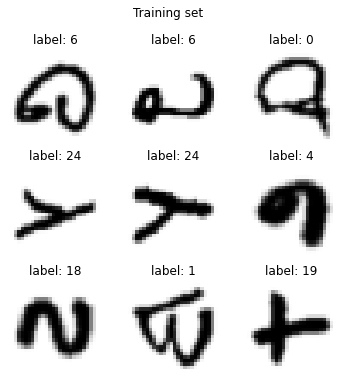

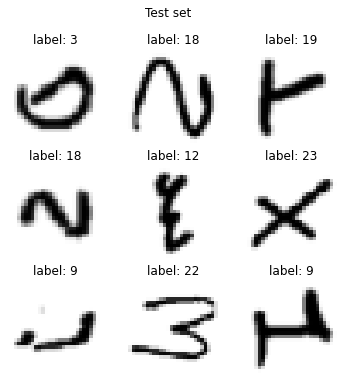

In [6]:
import matplotlib.pyplot as plt
import random
# select random samples from training dataset
train_samples = random.sample(range(0, len(x_train)), 9)
test_samples = random.sample(range(0, len(x_val)), 9)

x_train
plt.figure(figsize=(6, 6))
plt.suptitle('Training set')
for i in train_samples:
    plt.subplot(3, 3, train_samples.index(i)+1)
    plt.imshow(x_train.iloc[i,:].values.reshape(28,28), cmap='binary')
    plt.title(f'label: {y_train.iloc[i]}')
    plt.axis('off')
    
plt.figure(figsize=(6, 6))
plt.suptitle('Test set')
for i in test_samples:
    plt.subplot(3, 3, test_samples.index(i)+1)
    plt.imshow(x_val.iloc[i,:].values.reshape(28,28), cmap='binary')
    plt.title(f'label: {y_val.iloc[i]}')
    plt.axis('off')

### **Creating the CNN Model**


In [7]:
import tensorflow as tf
    

def train_model():
    # define model
    model = tf.keras.models.Sequential([
        # initial normalization
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(784,)),        
        
        # first convolution
        tf.keras.layers.Conv2D(8, (3, 3), activation='relu'), # applies kernels to our data
        tf.keras.layers.MaxPooling2D(2, 2), # reduce dimension
        
        # second convolution
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        
        # third convolution
        tf.keras.layers.Conv2D(24, (3, 3), activation='relu'),
    
        # feed to DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(classes), activation=tf.nn.softmax) # generalized logistic regression
    ])
    
    # use sparse categorical crossentropy since values are labeled from 0-25
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### **What have we implemented/experimented in this neural network so far?**
We have the following layers in our CNN:
* **Convolutional layers** - what convolutional layers do is that it applies various kernels on the image to extract or identify important features that we will feed into the neural network

* **Pooling filters** - pooling helps reduce the spatial size of an image to reduce the amount of parameters when computing for the output. Progressively reducing the dimensions (down sampling) of the images/feature representations in each convolution will later help reducing the computational cost of the neural network

In [8]:
# view model summary before running neural network
model = train_model()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 24)          3480      
_________________________________________________________________
flatten (Flatten)            (None, 216)               0

## **Training the neural network:**
So far we've defined some the parameters of our neural network . We also created a training and validation split. Now we'll use these data to train our model

In [9]:
history = model.fit(x_train, y_train, epochs=65,
                    validation_data=(x_val, y_val),
                    batch_size=4096,
                    verbose=1)

Epoch 1/65
18/18 [==============================] - 14s 737ms/step - loss: 3.2045 - accuracy: 0.0744 - val_loss: 2.8355 - val_accuracy: 0.3366
Epoch 2/65
18/18 [==============================] - 12s 645ms/step - loss: 2.5360 - accuracy: 0.3912 - val_loss: 1.7323 - val_accuracy: 0.4980
Epoch 3/65
18/18 [==============================] - 11s 634ms/step - loss: 1.6027 - accuracy: 0.5321 - val_loss: 1.3215 - val_accuracy: 0.6023
Epoch 4/65
18/18 [==============================] - 12s 673ms/step - loss: 1.2507 - accuracy: 0.6255 - val_loss: 1.1226 - val_accuracy: 0.6673
Epoch 5/65
18/18 [==============================] - 12s 644ms/step - loss: 1.0649 - accuracy: 0.6814 - val_loss: 0.9790 - val_accuracy: 0.7104
Epoch 6/65
18/18 [==============================] - 12s 658ms/step - loss: 0.9283 - accuracy: 0.7214 - val_loss: 0.8754 - val_accuracy: 0.7347
Epoch 7/65
18/18 [==============================] - 12s 645ms/step - loss: 0.8252 - accuracy: 0.7478 - val_loss: 0.7898 - val_accuracy: 0.7583

## **Visualizing the convolution and pooling filters**
This visualization will let us see the features that our neural network learned as it passed through the convolutions. **Observe that specific parts of the letter lights up** in each layer. We can interpret this as the network identifying those features of the letter

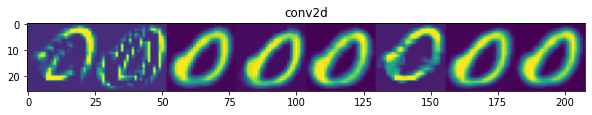

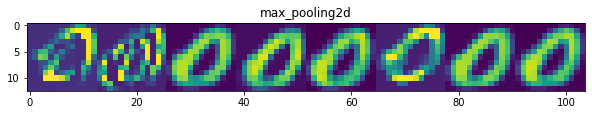

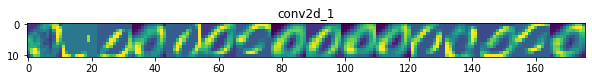

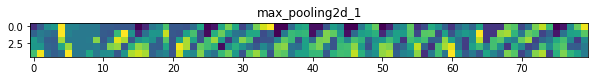

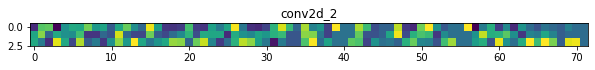

In [10]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

number = random.sample(range(0, len(x_val)), 1)[0]

# Run the image through the network and return the intermediate representations for the data.
successive_feature_maps = visualization_model.predict(x_val.iloc[number, :].to_numpy().reshape(1, 784))

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 10. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

**By visualizing each convolution and pooling layer, we will have an idea of what 'features' are being learned by our neural network**. For example, it may be trying to identify specific edges and curves, or even 'holes' for specific letters. Pooling helps down sample these features so our neural network will be able to train faster

## **Plotting the losses and the accuracy of the training and validation set**
Let's see how our model performs as we increase the number of epochs. Plotting the accuracy and loss over time gives us an idea well our neural network is performing for each epoch.

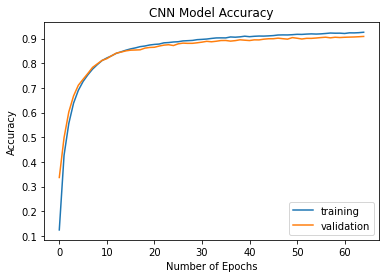

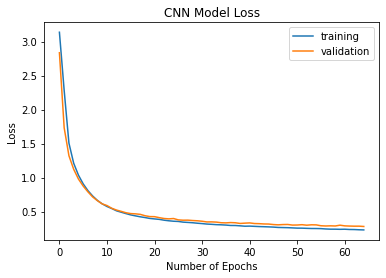

In [11]:
# Plot training vs validation accruacy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# Plot training vs validation losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Number of Epochs')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## **Neural network evaluation**
Here we will evaluate the performace of our neural network by using the test set. Based on the output, there will be instances that the predicted will be different from the actual label.

In [12]:
evaluate = model.evaluate(x_test, y_test)

# predict values for all data
predictions = model.predict(x_test)
print("predictions shape:", predictions.shape)


463/463 [==============================] - 3s 5ms/step - loss: 0.3220 - accuracy: 0.8955
predictions shape: (14799, 26)


### **What does our evaluation accuracy mean?**
* If our training accuracy is significantly higher that our validation accuracy, it means that we are overfitiing our training data. This will result to our neural network performing poorly in our validation and test data. 

* In our case, however, we can see that our test accuracy is fairly close with our training and  validation accuracy. This means that our CNN generalized well with our test data.

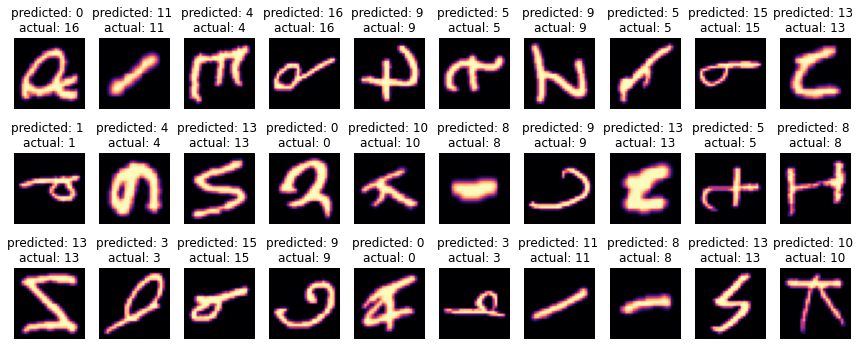

In [13]:
# select random data from test set and predict it's classification
test_samples = random.sample(range(0, len(x_test)), 30) # select 30 samples

# display results
plt.figure(figsize=(15, 6))
for i in test_samples:
    plt.subplot(3, 10, test_samples.index(i) + 1)  
    plt.imshow(x_test[i].reshape(28,28), cmap='magma')
    plt.title(f'predicted: {np.argmax(predictions[i])} \nactual: {y_test[i]}')
    plt.axis('off')

In [14]:
# Save the model
model.save("final_model.h5")